In [19]:
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import json
import matplotlib.pyplot as plt

In [2]:
data_dir = Path('/Users/djemec/data/jepa/v0_2')
tok_dir = data_dir / 'training'
train_path = tok_dir /'train'
test_path  = tok_dir /'test'

In [3]:
def get_ids(path, name):
    ids = set()
    files = list(path.glob('*.npz'))
    print(f"Checking {len(files)} files in {name}...")
    
    for f in tqdm(files):
        try:
            with np.load(f) as data:
                # We only care about the 'action_ids' array
                unique_actions = np.unique(data['action_ids'])
                ids.update(unique_actions)
        except Exception as e:
            print(f"Skipping {f}: {e}")
            
    return ids

In [4]:
train_ids = get_ids(train_path, "TRAIN")
test_ids  = get_ids(test_path, "TEST")

Checking 5 files in TRAIN...


100%|████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 771.58it/s]


Checking 2 files in TEST...


100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 831.54it/s]


In [5]:
overlap = train_ids.intersection(test_ids)
overlap

set()

## Check perturbation embeddings

In [6]:
pert_dir = data_dir / 'pert_embd'
embd = np.load(pert_dir / 'action_embeddings_esm2.npy')

In [7]:
train_indices = list(train_ids)
test_indices = list(test_ids)
len(train_indices), len(test_indices)

(733, 272)

In [8]:
train_vecs = embd[train_indices]
test_vecs = embd[test_indices]

In [9]:
# Compute similarity matrix
sim_matrix = cosine_similarity(test_vecs, train_vecs)

In [10]:
# Find the max similarity for each test gene
max_sim = sim_matrix.max(axis=1)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  1.,  1.,  2.,  0.,  2.,  0.,  3.,  2.,  2.,
         0.,  5.,  4.,  4.,  3.,  5.,  8.,  4.,  8., 10., 12.,  8., 19.,
        15., 22., 20., 17., 32., 17., 22.,  8.,  6.]),
 array([0.80132157, 0.80325544, 0.80518925, 0.80712312, 0.80905694,
        0.81099081, 0.81292462, 0.8148585 , 0.81679231, 0.81872618,
        0.82066   , 0.82259387, 0.82452768, 0.82646155, 0.82839543,
        0.83032924, 0.83226311, 0.83419693, 0.8361308 , 0.83806461,
        0.83999848, 0.8419323 , 0.84386617, 0.84579998, 0.84773386,
        0.84966767, 0.85160154, 0.85353541, 0.85546923, 0.8574031 ,
        0.85933691, 0.8612

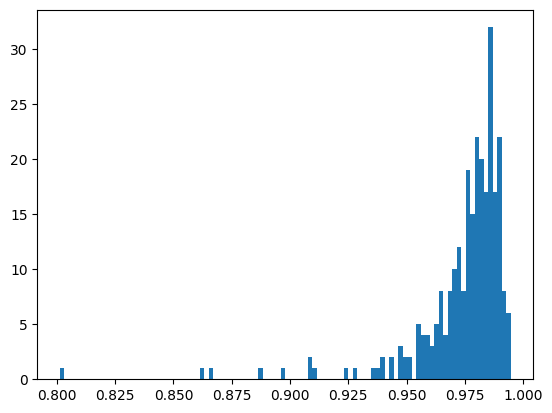

In [24]:
plt.hist(max_sim, bins = 100)

In [18]:
print(f'Average Max Similarity to Train: {max_sim.mean():.4f}')
print(f'Num Test Genes with >0.99 similarity: {np.sum(max_sim > 0.99)}')
print(f'Num Test Genes with >0.95 similarity: {np.sum(max_sim > 0.95)}')
print(f'Num Test Genes with <0.90 similarity: {np.sum(max_sim < 0.90)}')

Average Max Similarity to Train: 0.9742
Num Test Genes with >0.99 similarity: 25
Num Test Genes with >0.95 similarity: 251
Num Test Genes with <0.90 similarity: 5


In [12]:
with open(pert_dir / 'pert_to_id.json', 'r') as f:
    pert_to_id = json.load(f)
id_to_pert = {v: k for k, v in pert_to_id.items()}

In [17]:

print(f'{'TEST GENE':<20} | {'TRAIN GENE':<20} | {'COSINE SIMILARITY'}')
count = 0
for i in range(len(test_indices)):
    match_indices = np.where(sim_matrix[i] > 0.99)[0]
    
    for j in match_indices:
        test_gene_id = test_indices[i]
        train_gene_id = train_indices[j]
        
        test_name = id_to_pert[test_gene_id]
        train_name = id_to_pert[train_gene_id]
        score = sim_matrix[i, j]
        
        print(f'{test_name:<20} | {train_name:<20} | {score:.4f}')
        count += 1

TEST GENE            | TRAIN GENE           | COSINE SIMILARITY
VPS54                | COG3                 | 0.9928
VPS54                | NCKAP1               | 0.9920
VPS54                | RINT1                | 0.9926
WDR70                | DYNC1I2              | 0.9903
XPO1                 | CSE1L                | 0.9929
XPO1                 | TRRAP                | 0.9903
XRCC6                | XRCC5                | 0.9900
POLR1E               | CCNH                 | 0.9923
POLR1E               | KCTD10               | 0.9920
COG2                 | COG3                 | 0.9901
POLR3B               | POLR1B               | 0.9906
POLR3B               | POLR2A               | 0.9910
POLR3B               | POLR2B               | 0.9923
CUL1                 | CUL2                 | 0.9932
PSMA2                | AARS                 | 0.9919
PSMA2                | MAT2A                | 0.9930
PSMA2                | NIP7                 | 0.9930
PSMA2                | PSMA7       